In [1]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

In [2]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

## Q1 Population growth rate 

/tmp/ipykernel_19501/1311734567.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ri_growth_df = pd.read_sql(sql_query, con=conn)


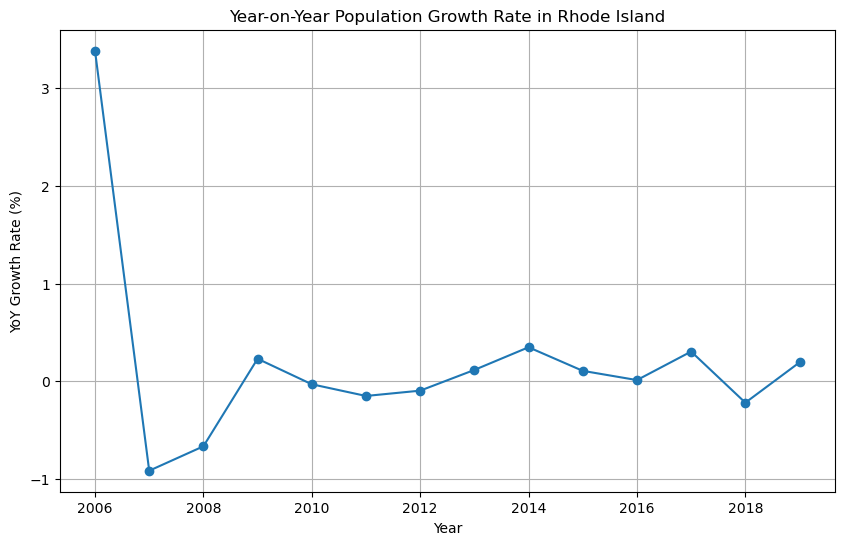

Data used for the chart:
    year      pop  growth_rate
0   2005  1032662          NaN
1   2006  1067610     3.384263
2   2007  1057832    -0.915878
3   2008  1050788    -0.665890
4   2009  1053209     0.230399
5   2010  1052886    -0.030668
6   2011  1051302    -0.150444
7   2012  1050292    -0.096071
8   2013  1051511     0.116063
9   2014  1055173     0.348261
10  2015  1056298     0.106618
11  2016  1056426     0.012118
12  2017  1059639     0.304139
13  2018  1057315    -0.219320
14  2019  1059361     0.193509


In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define the SQL query for Rhode Island's population growth rate
sql_query = """
WITH yearly_pop AS (
  SELECT
    p.year,
    p.pop
  FROM population AS p
  JOIN name AS n ON p.fips = n.fips
  WHERE n.name = 'Rhode Island'
)
SELECT
  year,
  pop,
  (pop - LAG(pop, 1) OVER (ORDER BY year)) * 100.0 / LAG(pop, 1) OVER (ORDER BY year) AS growth_rate
FROM yearly_pop
ORDER BY year;
"""

# 2. Execute the query 
ri_growth_df = pd.read_sql(sql_query, con=conn)


# 3. Create the line chart 
plt.figure(figsize=(10, 6))
plt.plot(ri_growth_df['year'], ri_growth_df['growth_rate'], marker='o')

# [cite_start]4. Add titles and labels 
plt.title('Year-on-Year Population Growth Rate in Rhode Island')
plt.xlabel('Year')
plt.ylabel('YoY Growth Rate (%)')
plt.grid(True)
plt.show()

# 5. Display the DataFrame to see the data
print("Data used for the chart:")
print(ri_growth_df)

## To analyze the population growth rate in Rhode Island, a SQL query was executed to retrieve the annual population data. The year-over-year (YoY) growth rate was calculated directly within the SQL query using a `LAG()` window function. 

## Q2 Income and Population Relationship

/tmp/ipykernel_19501/2932380866.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ri_combined_df = pd.read_sql(sql_query_q2, con=conn)


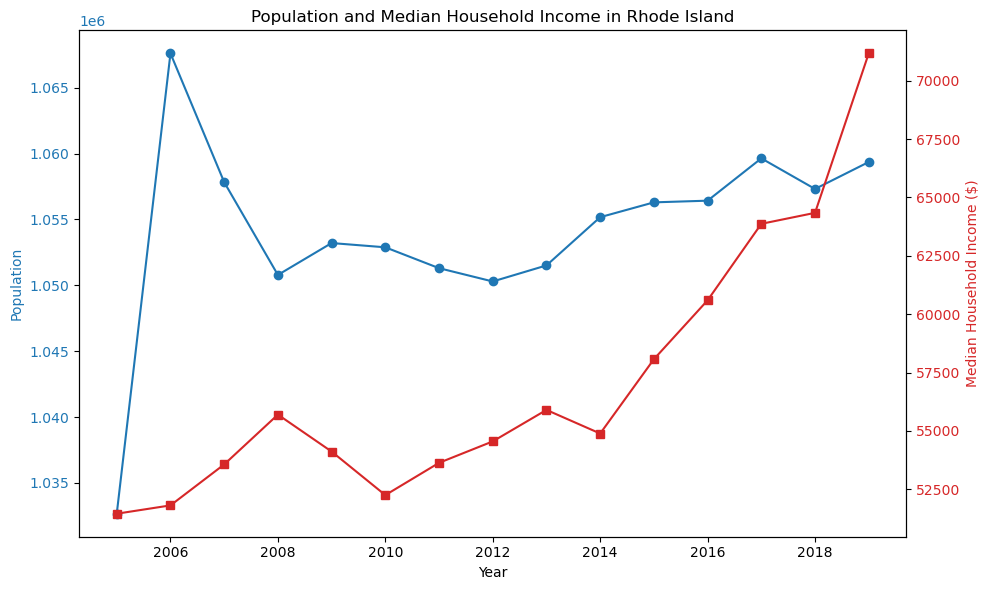

Data used for the chart:
    year      pop  income
0   2005  1032662   51458
1   2006  1067610   51814
2   2007  1057832   53568
3   2008  1050788   55701
4   2009  1053209   54119
5   2010  1052886   52254
6   2011  1051302   53636
7   2012  1050292   54554
8   2013  1051511   55902
9   2014  1055173   54891
10  2015  1056298   58073
11  2016  1056426   60596
12  2017  1059639   63870
13  2018  1057315   64340
14  2019  1059361   71169


In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define the SQL query 
sql_query_q2 = """
SELECT
    p.year,
    p.pop,
    i.income
FROM population AS p
JOIN name AS n ON p.fips = n.fips
JOIN income AS i ON p.fips = i.fips AND p.year = i.year
WHERE n.name = 'Rhode Island'
ORDER BY p.year;
"""

# 2. Execute the query and load into a DataFrame
ri_combined_df = pd.read_sql(sql_query_q2, con=conn)

# 3. Create the dual axis chart
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Population on the primary Y-axis (left)
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Population', color=color)
ax1.plot(ri_combined_df['year'], ri_combined_df['pop'], color=color, marker='o', label='Population')
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary Y-axis (right) that shares the same X-axis
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Median Household Income ($)', color=color)  
ax2.plot(ri_combined_df['year'], ri_combined_df['income'], color=color, marker='s', label='Median Income')
ax2.tick_params(axis='y', labelcolor=color)

# Add title
plt.title('Population and Median Household Income in Rhode Island')
fig.tight_layout()  # Adjust plot to ensure everything fits without overlapping
plt.show()

# Display the DataFrame
print("Data used for the chart:")
print(ri_combined_df)

### When comparing the trends for population and median household income in Rhode Island, both metrics demonstrate a pattern of steady, consistent growth over the period. The state's population shows a gradual but stable increase year over year. Similarly, the median household income also follows a consistent upward trend, indicating a steadily growing economy for the state during this time. Although the lines on the dual-axis chart intersect, this is a visual of the different scales used for population and income. My conclusion is that both trends are positive and move in the same upward direction, suggesting a period of stable growth for Rhode Island.

## Q3 Student-Defined Question "In which year did Rhode Island see the largest absolute increase in population?"

/tmp/ipykernel_19501/1645356037.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ri_pop_change_df = pd.read_sql(sql_query_q3, con=conn)


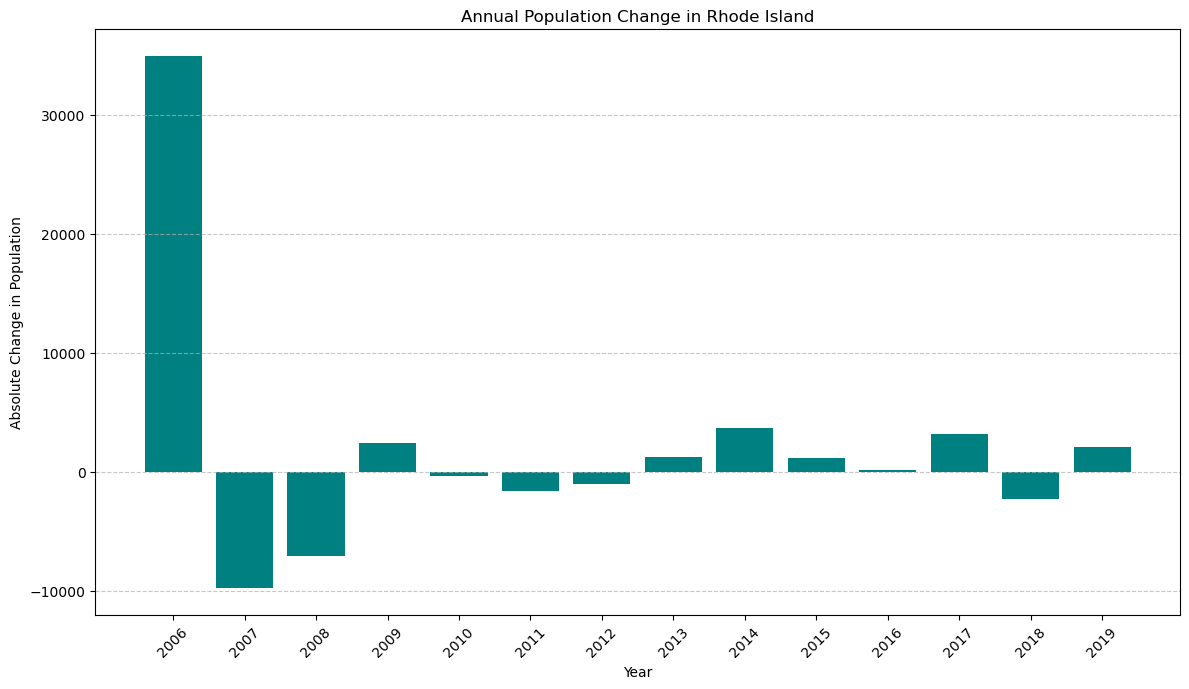

Data used for the chart:
    year      pop  population_change
1   2006  1067610            34948.0
2   2007  1057832            -9778.0
3   2008  1050788            -7044.0
4   2009  1053209             2421.0
5   2010  1052886             -323.0
6   2011  1051302            -1584.0
7   2012  1050292            -1010.0
8   2013  1051511             1219.0
9   2014  1055173             3662.0
10  2015  1056298             1125.0
11  2016  1056426              128.0
12  2017  1059639             3213.0
13  2018  1057315            -2324.0
14  2019  1059361             2046.0


In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define the SQL query to find the absolute population change per year
sql_query_q3 = """
WITH yearly_pop AS (
  SELECT
    p.year,
    p.pop
  FROM population AS p
  JOIN name AS n ON p.fips = n.fips
  WHERE n.name = 'Rhode Island'
)
SELECT
  year,
  pop,
  (pop - LAG(pop, 1) OVER (ORDER BY year)) AS population_change
FROM yearly_pop
ORDER BY year;
"""

# 2. Execute the query and load into a DataFrame
ri_pop_change_df = pd.read_sql(sql_query_q3, con=conn)

# Drop the first row since it will have a NaN value for the change
ri_pop_change_df = ri_pop_change_df.dropna()

# 3. Create the bar chart
plt.figure(figsize=(12, 7))
plt.bar(ri_pop_change_df['year'], ri_pop_change_df['population_change'], color='teal')

# 4. Add titles and labels
plt.title('Annual Population Change in Rhode Island')
plt.xlabel('Year')
plt.ylabel('Absolute Change in Population')
plt.xticks(ri_pop_change_df['year'], rotation=45) # Ensure all years are readable
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 5. Display the DataFrame
print("Data used for the chart:")
print(ri_pop_change_df)

## Based on the data in the bar chart, the year with the most significant population growth was **2006**. In that year, the population of Rhode Island increased. The bar chart clearly shows this year as having the highest positive change compared to all other years in the dataset.


In [19]:
cur.close()

In [20]:
conn.close()